Based on the full data subset A with no missing data, the full samples for y=0 and y=1 are learned and new samples are generated using the data and labels from tp2.

In [1]:
import os
import warnings
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from torch.utils.data import TensorDataset, DataLoader
from skbio.stats.composition import clr, alr, ilr
from scipy.cluster.hierarchy import linkage, fcluster, cut_tree
from scipy.spatial.distance import pdist, cdist
from scipy.stats.mstats import gmean
from scipy.stats import gaussian_kde, gamma, dirichlet, multivariate_normal
from scipy.special import softmax
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
class ConditionalGaussianMixtureModel:
    
    def __init__(self, n_components=2, max_iter=100, tol=1e-3, random_state=None): 
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        np.random.seed(random_state)
        
    def _initialize_parameters(self, X, C):
        n_samples, n_features = X.shape
        n_conditions = C.shape[1]
        
        # Initialize using K-means
        kmeans = KMeans(n_clusters=self.n_components, random_state=self.random_state)
        labels = kmeans.fit_predict(X)
        
        # Initialize weight parameters (related to conditional variables)
        self.weight_coeffs = np.random.randn(self.n_components, n_conditions + 1)
        
        # Initialize mean parameters (related to conditional variables)
        self.mean_coeffs = np.zeros((self.n_components, n_features, n_conditions + 1))
        for k in range(self.n_components):
            mask = (labels == k)
            if np.sum(mask) > 0:
                self.mean_coeffs[k, :, 0] = np.mean(X[mask], axis=0)
        
        # Initialize covariance matrices (assume they're independent of conditional variables for now)
        self.covariances = np.zeros((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            mask = (labels == k)
            if np.sum(mask) > 0:
                diff = X[mask] - self.mean_coeffs[k, :, 0]
                self.covariances[k] = np.dot(diff.T, diff) / np.sum(mask)
            else:
                self.covariances[k] = np.eye(n_features)
                
        # Ensure covariance matrices are positive definite
        for k in range(self.n_components):
            self.covariances[k] += 1e-6 * np.eye(n_features)
    
    def _e_step(self, X, C):
        """
        E-step: Calculate posterior probability of each sample belonging to each component
        """
        n_samples = X.shape[0]
        log_prob = np.zeros((n_samples, self.n_components))
        
        # Calculate weight for each component (dependent on conditional variables)
        C_bias = np.hstack([np.ones((n_samples, 1)), C])
        weights = self._compute_weights(C_bias)
        
        # Calculate mean for each component (dependent on conditional variables)
        means = self._compute_means(C_bias)
        
        # Calculate log probability of each sample under each component
        for k in range(self.n_components):
            for i in range(n_samples):
                log_prob[i, k] = np.log(weights[i, k] + 1e-10) + multivariate_normal.logpdf(
                    X[i], mean=means[i, k], cov=self.covariances[k], allow_singular=True)
        
        # Calculate posterior probabilities (responsibilities)
        log_prob_max = np.max(log_prob, axis=1, keepdims=True)
        log_prob -= log_prob_max
        prob = np.exp(log_prob)
        responsibilities = prob / np.sum(prob, axis=1, keepdims=True)
        
        return responsibilities
    
    def _m_step(self, X, C, responsibilities):
        """
        M-step: Update model parameters
        """
        n_samples, n_features = X.shape
        n_conditions = C.shape[1]
        
        # Add bias term for M-step
        C_bias = np.hstack([np.ones((n_samples, 1)), C])
        
        # Update weight coefficients
        for k in range(self.n_components):
            # Set up weighted least squares problem
            W = np.sqrt(responsibilities[:, k, np.newaxis])
            y = W
            X_weighted = W * C_bias
            
            # Solve weighted least squares problem
            self.weight_coeffs[k] = np.linalg.lstsq(X_weighted, y, rcond=None)[0].flatten()
        
        # Update mean coefficients
        for k in range(self.n_components):
            for d in range(n_features):
                # Set up weighted least squares problem
                W = np.sqrt(responsibilities[:, k, np.newaxis])
                y = W * X[:, d, np.newaxis]
                X_weighted = W * C_bias
                
                # Solve weighted least squares problem
                self.mean_coeffs[k, d] = np.linalg.lstsq(X_weighted, y, rcond=None)[0].flatten()
        
        # Update covariance matrices (assume they're independent of conditional variables for now)
        means = self._compute_means(C_bias)
        
        for k in range(self.n_components):
            self.covariances[k] = np.zeros((n_features, n_features))
            weighted_sum = 0
            
            for i in range(n_samples):
                diff = X[i] - means[i, k]
                self.covariances[k] += responsibilities[i, k] * np.outer(diff, diff)
                weighted_sum += responsibilities[i, k]
            
            self.covariances[k] /= (weighted_sum + 1e-10)
            
            # Ensure covariance matrices are positive definite
            self.covariances[k] += 1e-6 * np.eye(n_features)
    
    def _compute_weights(self, C_bias):
        """
        Calculate weight for each sample under each component
        """
        n_samples = C_bias.shape[0]
        logits = np.dot(C_bias, self.weight_coeffs.T)
        
        # Use softmax to ensure weights are positive and sum to 1
        logits_max = np.max(logits, axis=1, keepdims=True)
        logits -= logits_max
        exp_logits = np.exp(logits)
        weights = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        
        return weights
    
    def _compute_means(self, C_bias):
        """
        Calculate mean for each sample under each component
        """
        n_samples = C_bias.shape[0]
        n_features = self.mean_coeffs.shape[1]
        
        means = np.zeros((n_samples, self.n_components, n_features))
        for k in range(self.n_components):
            for d in range(n_features):
                means[:, k, d] = np.dot(C_bias, self.mean_coeffs[k, d])
                
        return means
    
    def fit(self, X, C):
        """
        Fit conditional Gaussian mixture model using EM algorithm
        """
        # Initialize parameters
        self._initialize_parameters(X, C)
        
        # EM algorithm iterations
        prev_log_likelihood = -np.inf
        
        for iteration in range(self.max_iter):
            # E-step: Calculate posterior probabilities
            responsibilities = self._e_step(X, C)
            
            # M-step: Update parameters
            self._m_step(X, C, responsibilities)
            
            # Calculate log likelihood
            C_bias = np.hstack([np.ones((X.shape[0], 1)), C])
            weights = self._compute_weights(C_bias)
            means = self._compute_means(C_bias)
            
            log_likelihood = 0
            for i in range(X.shape[0]):
                component_log_probs = []
                for k in range(self.n_components):
                    component_log_prob = np.log(weights[i, k] + 1e-10) + multivariate_normal.logpdf(
                        X[i], mean=means[i, k], cov=self.covariances[k], allow_singular=True)
                    component_log_probs.append(component_log_prob)
                
                log_likelihood += self._log_sum_exp(np.array(component_log_probs))
            
            # Check for convergence
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
                
            prev_log_likelihood = log_likelihood
            
        return self
    
    def _log_sum_exp(self, log_probs):
        """
        Calculate log-sum-exp to avoid numerical overflow
        """
        max_log_prob = np.max(log_probs)
        return max_log_prob + np.log(np.sum(np.exp(log_probs - max_log_prob)))
    
    def predict(self, X, C):
        """
        Predict cluster labels for samples
        """
        responsibilities = self._e_step(X, C)
        return np.argmax(responsibilities, axis=1)
    
    def predict_proba(self, X, C):
        """
        Predict probability of samples belonging to each component
        """
        return self._e_step(X, C)
    
    def sample(self, C, n_samples=1):
        """
        Generate samples based on conditional variables
        """
        rng = np.random.RandomState(self.random_state)
        
        C_bias = np.hstack([np.ones((C.shape[0], 1)), C])
        
        # Calculate mixture weights
        weights = self._compute_weights(C_bias)
        
        # Calculate mean for each component
        means = self._compute_means(C_bias)
        
        # Generate samples
        samples = []
        component_labels = []
        
        samples_per_condition = n_samples // C.shape[0]
        remainder = n_samples % C.shape[0]
        
        for i in range(C.shape[0]):
            # Determine number of samples to generate for current condition
            n_current = samples_per_condition + (1 if i < remainder else 0)
            
            # Randomly select components
            k_samples = np.random.choice(
                self.n_components, 
                size=n_current, 
                p=weights[i]
            )
            
            # Generate samples from each selected component
            for k in k_samples:
                sample = np.random.multivariate_normal(
                    means[i, k], 
                    self.covariances[k]
                )
                samples.append(sample)
                component_labels.append(k)
                
        return np.array(samples), np.array(component_labels)

def conditional_gmm(X_train, y_train, tp2_train, minority_class=1, num_new_samples=100, n_components=2, random_state=42):
    # Get indices of minority class samples
    minority_indices = np.where(y_train == minority_class)[0]
    
    # Create conditional variables: tp2 data + labels
    C = np.column_stack([tp2_train, y_train.reshape(-1, 1)])
    
    # Create and fit conditional Gaussian mixture model
    cgmm = ConditionalGaussianMixtureModel(n_components=n_components, random_state=random_state)
    cgmm.fit(X_train, C)
    
    # Prepare conditions for generating samples
    # Method 1: Use conditions from all minority class samples
    minority_conditions = C[minority_indices]
    
    # If number of minority samples is less than requested new samples, reuse conditions
    if len(minority_indices) < num_new_samples:
        # Calculate number of repeats needed
        repeat_times = num_new_samples // len(minority_indices) + 1
        minority_conditions = np.tile(minority_conditions, (repeat_times, 1))[:num_new_samples]
    else:
        # Randomly select conditions from minority class samples
        random_indices = np.random.choice(len(minority_indices), num_new_samples, replace=False)
        minority_conditions = minority_conditions[random_indices]
    
    # Generate new samples using conditions
    new_samples, _ = cgmm.sample(minority_conditions, n_samples=num_new_samples)
    
    # Label all generated samples as minority class
    new_labels = np.full(num_new_samples, minority_class)
    
    return new_samples, new_labels

In [3]:
def evaluate_model(y_true, y_pred, y_pred_proba):
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp)
    balanced_accuracy = (sensitivity + specificity) / 2
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    return {
#         'Accuracy': accuracy,
        'Balanced_accuracy': balanced_accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
#         'F1 Score': f1,
        'AUC': auc
    }

In [4]:
pd.set_option('future.no_silent_downcasting', True)

In [5]:
def set_all_seeds(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = "0"
    
set_all_seeds(42)

In [6]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.base")

In [7]:
# Define K-fold cross-validation
# 1. There are positive samples in both the training and validation sets.
# 2. the class distributions in the training and validation sets are similar to the original dataset.

n_splits = 5
num_seeds = 5
skf = StratifiedKFold(n_splits= n_splits, shuffle=True, random_state = 42)

### metadata

In [8]:
Metadata = pd.read_csv("data/BASIC_metadata_full.csv", sep=',', low_memory=False)
Metadata = Metadata.drop(Metadata.columns[0], axis=1)

# convert timepoits to 0,1,2
Metadata.loc[Metadata.TimePoint == "Trimester2","TimePoint"] = 0 
Metadata.loc[Metadata.TimePoint == "Trimester3","TimePoint"] = 1
Metadata.loc[Metadata.TimePoint == "PostpartumWeek6","TimePoint"] = 2

# turn insufficient reads to NaN
i = Metadata[Metadata.ReadsNumber < 500000].index
Metadata.loc[i, 'ReadsNumber'] = np.nan

### species data

In [9]:
profile =pd.read_csv("data/Species_Profile_full.csv",sep=',',low_memory=False)

# extract all bacteria names
full_list_bacteria = list(profile.columns)[1:]

species = profile.to_numpy()[:,1:]

species_num = np.shape(species)[1] # 713 species

In [10]:
# Inner join profile and metadeata
merged_data_base = pd.merge(profile, Metadata, left_on='Sample_id', right_on='Sample_ID')

merged_data = merged_data_base.dropna(subset=['ReadsNumber'])[['Individual_ID', 'TimePoint', 'EPDS', 'Dichotomous_EPDS'] + full_list_bacteria]

In [11]:
# 1. Sample individuals whose EPDS != NaN at tp2
individuals_with_na_epds_at_tp2 = merged_data[
    (merged_data['TimePoint'] == 2) & (merged_data['EPDS'].isna())
]['Individual_ID'].unique()

data = merged_data[~merged_data['Individual_ID'].isin(individuals_with_na_epds_at_tp2)]

# 2. Sample individuals with data at tp0, tp1 and tp2
individuals_with_all_timepoints = data.groupby('Individual_ID').filter(lambda x: set(x['TimePoint']) >= {0, 1, 2})['Individual_ID'].unique()
data = data[data['Individual_ID'].isin(individuals_with_all_timepoints)]

In [12]:
# Remove features that have a value of 0 at all time points for all samples
columns_to_drop = []
for col in full_list_bacteria:
    if (data[col] == 0).all():
        columns_to_drop.append(col)
data = data.drop(columns=columns_to_drop)

# Update full_list_bacteria
full_list_bacteria = [col for col in full_list_bacteria if col not in columns_to_drop]

### （1）Pre-Processing

In [13]:
# 1.Replace the zero value by 1/2 of the non - zero minimum value
data[full_list_bacteria] = data[full_list_bacteria].astype(float)

# Replace with 1/2 of the non-zero minimum value of the row
matrix = data[full_list_bacteria].values
for i in range(matrix.shape[0]):
    row = matrix[i, :]
    non_zero_values = row[~np.isnan(row) & (row > 0)]
    if len(non_zero_values) > 0:
        min_non_zero = np.min(non_zero_values)
        half_min = min_non_zero / 2
        row[row == 0] = half_min
    matrix[i, :] = row

data[full_list_bacteria] = matrix

In [14]:
# Normalization
for i in range(matrix.shape[0]):
    row = matrix[i, :]
    
    row_sum = np.sum(row)
    row = row / row_sum
    matrix[i, :] = row

data[full_list_bacteria] = matrix

In [15]:
# Turn data from [individual * tp, feature] into [individual, tp, feature]
grouped = data.groupby('Individual_ID')

transformed_data = []
labels = []

for individual_id, group in grouped:
    time_point_matrix = np.full((3, len(full_list_bacteria)), np.nan)

    for _, row in group.iterrows():
        time_point = int(row['TimePoint'])
        time_point_matrix[time_point] = row[full_list_bacteria].values

    tp2_row = group[group['TimePoint'] == 2]
    label = tp2_row['Dichotomous_EPDS'].values[0]

    transformed_data.append(time_point_matrix)
    labels.append(label)

transformed_data = np.array(transformed_data)
labels = np.array(labels)

In [16]:
print("minority class：", len(labels[labels == 1]))
print("majority class：", len(labels[labels == 0]))

minority class： 15
majority class： 70


In [17]:
# Build an RF model on the data to make predictions with only CLR.
# There are a lot of NAs in features
X = transformed_data[:, :2, :].reshape(transformed_data.shape[0], -1)
y = labels

metrics_list = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    for seed in range(num_seeds):
        rf = RandomForestClassifier(n_estimators=100, random_state=seed, class_weight="balanced")
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        y_pred_proba = rf.predict_proba(X_val)[:, 1]

        metrics = evaluate_model(y_val, y_pred, y_pred_proba)
        metrics_list.append(metrics)

avg_metrics = {
    'Balanced_accuracy': np.mean([m['Balanced_accuracy'] for m in metrics_list]),
    'Sensitivity': np.mean([m['Sensitivity'] for m in metrics_list]),
    'Specificity': np.mean([m['Specificity'] for m in metrics_list]),
    'AUC': np.mean([m['AUC'] for m in metrics_list]),
}

std_metrics = {
    'Balanced_accuracy': np.std([m['Balanced_accuracy'] for m in metrics_list]),
    'Sensitivity': np.std([m['Sensitivity'] for m in metrics_list]),
    'Specificity': np.std([m['Specificity'] for m in metrics_list]),
    'AUC': np.std([m['AUC'] for m in metrics_list]),
}

print("Average Results:")
for metric, value in avg_metrics.items():
    print(f"  {metric}: {value:.4f} ± {std_metrics[metric]:.4f}")

Average Results:
  Balanced_accuracy: 0.5000 ± 0.0000
  Sensitivity: 0.0000 ± 0.0000
  Specificity: 1.0000 ± 0.0000
  AUC: 0.5871 ± 0.1759


### （2）Feature Extraction + OverSampling

OverSampling is performed using cGMM as the bottom, at which time no data transformations are performed to compare the effectiveness of the feature extraction methods.

In [18]:
def extract_features(train_data, k):
    selected_features_tp0 = []
    selected_features_tp1 = []
    
    for time_point in [0, 1]:
        time_point_data = train_data[train_data['TimePoint'] == time_point]
        
        X = time_point_data.drop(['Individual_ID', 'TimePoint', 'EPDS', 'Dichotomous_EPDS'], axis=1)
        y = time_point_data['Dichotomous_EPDS']

        selector = SelectKBest(score_func=f_classif, k=k) 
        X_new = selector.fit_transform(X, y)

        feature_indices = selector.get_support(indices=True)
        feature_columns = X.columns[feature_indices]
        
        if time_point == 0:
            selected_features_tp0 = feature_columns
        elif time_point == 1:
            selected_features_tp1 = feature_columns
            
    feature_columns = list(set(selected_features_tp0) | set(selected_features_tp1))
#     print(f"Selected features: {feature_columns}")
    
    return feature_columns

In [19]:
def extracted_datasets(data, feature_columns):
    unused_bacteria_columns = [col for col in full_list_bacteria if col not in feature_columns]
    others_column = data[unused_bacteria_columns].sum(axis=1).to_frame(name='Others')
    
    extracted_data = data[['Individual_ID', 'TimePoint', 'EPDS', 'Dichotomous_EPDS'] + list(feature_columns)]
    extracted_data = pd.concat([extracted_data, others_column], axis=1)
    
    return extracted_data

In [20]:
def clr_transform(data):
    data_copy = data.copy()
    id_columns = data_copy.columns[:4]
    microbiome_columns = data_copy.columns[4:]

    for _, group in data_copy.groupby('TimePoint'):
        indices = group.index
        group_data = group[microbiome_columns].values
        clr_values = clr(group_data)
        data_copy.loc[indices, microbiome_columns] = clr_values

    return data_copy

In [21]:
def reshape_and_extract_labels(extracted_data, feature_columns):
    # turn data from [individual * tp, feature] into [individual, tp, feature]
    grouped = extracted_data.groupby('Individual_ID')

    extracted_data_final = []
    labels = []

    for individual_id, group in grouped:
        time_point_matrix = np.full((3, len(feature_columns)), np.nan)

        for _, row in group.iterrows():
            time_point = int(row['TimePoint'])
            time_point_matrix[time_point] = row[feature_columns].values

        tp2_row = group[group['TimePoint'] == 2]
        label = tp2_row['Dichotomous_EPDS'].values[0]

        extracted_data_final.append(time_point_matrix)
        labels.append(label)

    extracted_data_final = np.array(extracted_data_final)
    labels = np.array(labels)

    return extracted_data_final, labels

In [22]:
# Assuming the number of new samples generated
num_new_samples = 55 # 70-15 = 55
original_num_time_steps = 2
minority_class = 1

In [23]:
individual_ids = np.unique(data['Individual_ID'])
y_for_fold = labels

### cGMM

#### Based on tp0&1 data and labels

In [26]:
results_by_k = {}

# Loop through different k values
for k in range(1, 11):
    print(f"Processing k = {k}")
    metrics_list = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(individual_ids, y_for_fold)):
        train_ids = individual_ids[train_idx]
        val_ids = individual_ids[val_idx]
        train_data = data[data['Individual_ID'].isin(train_ids)]
        val_data = data[data['Individual_ID'].isin(val_ids)]
        extracted_data_base = train_data.dropna(subset=['Dichotomous_EPDS'])
        
        # Use the current k value for feature extraction
        feature_columns = extract_features(extracted_data_base, k=k)
        extracted_data = extracted_datasets(data, feature_columns)
        extracted_data = clr_transform(extracted_data)
        feature_columns = feature_columns + ['Others']
        
        extracted_data_final, labels = reshape_and_extract_labels(extracted_data, feature_columns)
        X = extracted_data_final[:, :2, :].reshape(extracted_data_final.shape[0], -1)
        y = labels
        
        X_train = X[train_idx]
        X_val = X[val_idx]
        y_train = y[train_idx]
        y_val = y[val_idx]
        
        tp2_data = extracted_data_final[:, 2, :].reshape(len(extracted_data_final), -1)
        tp2_train = tp2_data[train_idx]
        
        minority_class = 1
        
        new_samples, new_labels = conditional_gmm(
            X_train, 
            y_train, 
            tp2_train,
            minority_class=minority_class,
            num_new_samples=num_new_samples,
        )
        
        combined_X_train = np.concatenate([X_train, new_samples], axis=0)
        combined_y_train = np.concatenate([y_train, new_labels], axis=0)
        
        for seed in range(num_seeds):
            rf = RandomForestClassifier(n_estimators=100, random_state=seed, class_weight="balanced")
            rf.fit(combined_X_train, combined_y_train)
            
            y_pred = rf.predict(X_val)
            y_pred_proba = rf.predict_proba(X_val)[:, 1]
            metrics = evaluate_model(y_val, y_pred, y_pred_proba)
            metrics_list.append(metrics)
    
    # Calculate average and standard deviation for this k value
    avg_metrics = {
        'Balanced_accuracy': np.mean([m['Balanced_accuracy'] for m in metrics_list]),
        'Sensitivity': np.mean([m['Sensitivity'] for m in metrics_list]),
        'Specificity': np.mean([m['Specificity'] for m in metrics_list]),
        'AUC': np.mean([m['AUC'] for m in metrics_list]),
    }
    std_metrics = {
        'Balanced_accuracy': np.std([m['Balanced_accuracy'] for m in metrics_list]),
        'Specificity': np.std([m['Specificity'] for m in metrics_list]),
        'Sensitivity': np.std([m['Sensitivity'] for m in metrics_list]),
        'AUC': np.std([m['AUC'] for m in metrics_list]),
    }
    
    # Store results for this k value
    results_by_k[k] = {
        'avg': avg_metrics,
        'std': std_metrics
    }
    
    print(f"Results for k = {k}:")
    for metric, value in avg_metrics.items():
        print(f"  {metric}: {value:.4f} ± {std_metrics[metric]:.4f}")
    print("-" * 50)

# Print a summary table of all k values for easy comparison
print("\nSummary of Results for all k values:")
print("k\tBalanced Accuracy\tSensitivity\tSpecificity\tAUC")
for k in range(1, 11):
    ba = results_by_k[k]['avg']['Balanced_accuracy']
    sens = results_by_k[k]['avg']['Sensitivity']
    spec = results_by_k[k]['avg']['Specificity']
    auc = results_by_k[k]['avg']['AUC']
    print(f"{k}\t{ba:.4f}\t\t{sens:.4f}\t\t{spec:.4f}\t\t{auc:.4f}")

Processing k = 1
Results for k = 1:
  Balanced_accuracy: 0.5129 ± 0.1558
  Sensitivity: 0.3200 ± 0.2207
  Specificity: 0.7057 ± 0.1543
  AUC: 0.4876 ± 0.1669
--------------------------------------------------
Processing k = 2
Results for k = 2:
  Balanced_accuracy: 0.6371 ± 0.1601
  Sensitivity: 0.5200 ± 0.2680
  Specificity: 0.7543 ± 0.1444
  AUC: 0.6600 ± 0.1227
--------------------------------------------------
Processing k = 3
Results for k = 3:
  Balanced_accuracy: 0.6143 ± 0.0920
  Sensitivity: 0.5600 ± 0.1555
  Specificity: 0.6686 ± 0.1524
  AUC: 0.5610 ± 0.1297
--------------------------------------------------
Processing k = 4
Results for k = 4:
  Balanced_accuracy: 0.6743 ± 0.1226
  Sensitivity: 0.6400 ± 0.2653
  Specificity: 0.7086 ± 0.1497
  AUC: 0.6233 ± 0.1511
--------------------------------------------------
Processing k = 5
Results for k = 5:
  Balanced_accuracy: 0.6252 ± 0.1257
  Sensitivity: 0.4133 ± 0.2544
  Specificity: 0.8371 ± 0.0821
  AUC: 0.6224 ± 0.2107
------

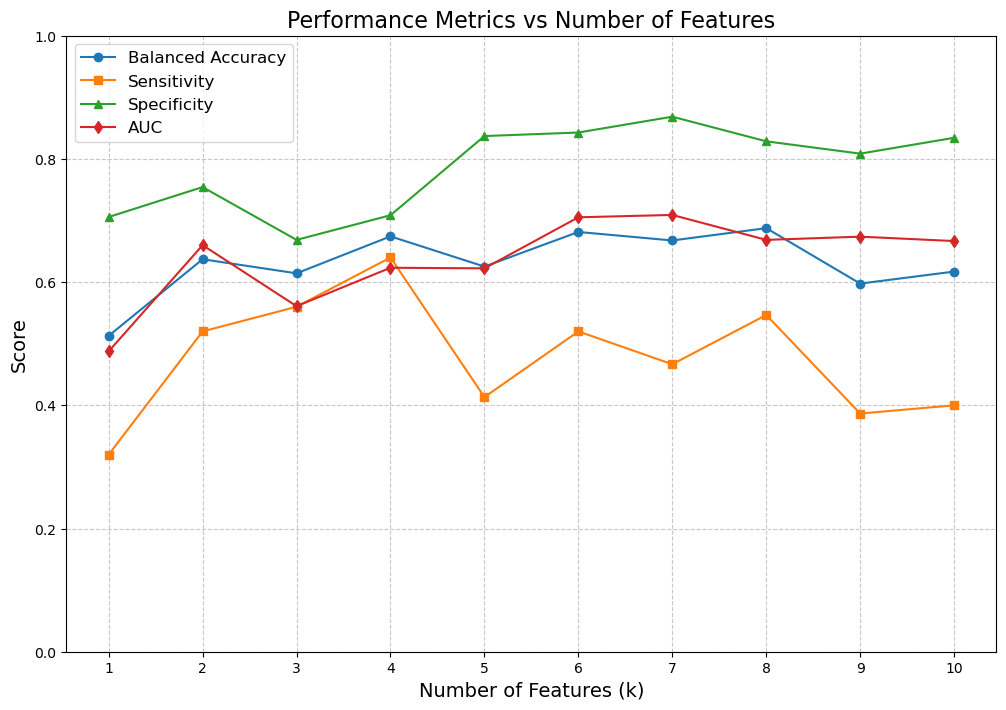

In [27]:
# Create a figure and axis
plt.figure(figsize=(12, 8))

# Extract data for plotting
k_values = list(range(1, 11))
balanced_accuracy = [results_by_k[k]['avg']['Balanced_accuracy'] for k in k_values]
sensitivity = [results_by_k[k]['avg']['Sensitivity'] for k in k_values]
specificity = [results_by_k[k]['avg']['Specificity'] for k in k_values]
auc = [results_by_k[k]['avg']['AUC'] for k in k_values]

# Plot each metric as a simple line with markers
plt.plot(k_values, balanced_accuracy, '-o', label='Balanced Accuracy')
plt.plot(k_values, sensitivity, '-s', label='Sensitivity')
plt.plot(k_values, specificity, '-^', label='Specificity')
plt.plot(k_values, auc, '-d', label='AUC')

# Add grid, legend and labels
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=12)
plt.xlabel('Number of Features (k)', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Performance Metrics vs Number of Features', fontsize=16)
plt.xticks(k_values)
plt.ylim([0, 1])

# Save the figure
plt.savefig('feature_selection_metrics.png', dpi=300, bbox_inches='tight')
plt.show()